# Dogs v Cats
**End to End Image Classification project using TensorFlow**

<img src="https://frenzy86.s3.eu-west-2.amazonaws.com/IFAO/cat_dog.gif" width="750" align="center">

This is subset of the original Dogs vs. Cats Dataset (**3000 images sampled from the original dataset of 25000 images**)

In [1]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O cats_and_dogs_filtered.zip

--2024-01-31 19:35:06--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.141.207, 142.251.2.207, 74.125.137.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.141.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘cats_and_dogs_filtered.zip’

cats_and_dogs_filte 100%[===================>]  65.43M   234MB/s    in 0.3s    

2024-01-31 19:35:06 (234 MB/s) - ‘cats_and_dogs_filtered.zip’ saved [68606236/68606236]



**Import libraries**

In [2]:
import os
import zipfile
from tensorflow.keras.preprocessing.image import ImageDataGenerator

The os library gives us access to the file system, and the zipfile library allows us to unzip the data.

**Create the respective directories**

In [3]:
local_zip = 'cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('')
zip_ref.close()

base_dir = 'cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')

# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')

# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

In [4]:

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

# Index for iterating over images
pic_index = 0

train_cat_fnames = os.listdir(train_cats_dir)
train_dog_fnames = os.listdir(train_dogs_dir)

In [5]:
# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

pic_index += 8
next_cat_pix = [os.path.join(train_cats_dir, fname) for fname in train_cat_fnames[pic_index-8:pic_index]]
next_dog_pix = [os.path.join(train_dogs_dir, fname) for fname in train_dog_fnames[pic_index-8:pic_index]]

for i, img_path in enumerate(next_cat_pix+next_dog_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()

Output hidden; open in https://colab.research.google.com to view.

**Model with 4 convolutional layers with 32, 64, 128 and 128 convolutions respectively**

We add convolutional layers, and flatten the final result to feed into the densely connected layers.
As this is a 2 class classification problem, we use the [Sigmoid function](https://en.wikipedia.org/wiki/Sigmoid_function)

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten

#input_shape=(150, 150, 3)
# Note the input shape is the desired size of the image 150x150 3 channels

model = Sequential()

# This is the first convolution
model.add(Conv2D(filters =32, kernel_size=(3,3), input_shape=(150, 150, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))

# The second convolution
model.add(Conv2D(filters =64, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(2,2))

# The third convolution
model.add(Conv2D(filters =128, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(2,2))

# The fourth convolution
model.add(Conv2D(filters =128, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(2,2))

# Flatten the results to feed into a DNN
model.add(Flatten())

# 512 neuron hidden layer
model.add(Dense(512, activation='relu'))
# Only 1 output neuron. It will contain a value from 0-1 where 0 for 1 class and 1 for the other
model.add(Dense(1, activation='sigmoid'))

In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 36, 36, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 17, 17, 128)       0

The "output shape" column shows how the size of your feature map evolves in each successive layer. The convolution layers reduce the size of the feature maps by a bit due to padding, and each pooling layer halves the dimensions.

We use binary_crossentropy as the loss metric as we have 2 target classes (its a binary classification problem)

Our optimizer is RMSprop with a learning rate of 0.0001 (We can experiment with this; Adam and Adagrad optimizers would also work well)


In [8]:
from tensorflow.keras.optimizers import RMSprop

model.compile(loss='binary_crossentropy',
              #optimizer=RMSprop(learning_rate=1e-4),
              optimizer=RMSprop(learning_rate=0.0001),
              metrics=['accuracy'])

**Rescale the Images**

The data generators read pictures in our source folders, convert them to float32 tensors, and feed them (with their labels) to our network. We'll have one generator for the training images and one for the validation images.

Input data to the neural networks should be normalized to aid in processing. We will preprocess our images by normalizing the pixel values to be in the [0, 1] range (originally all values are in the [0, 255] range).

In Keras this can be done via the keras.preprocessing.image.ImageDataGenerator class using the rescale parameter. This ImageDataGenerator class allows you to instantiate generators of augmented image batches (and their labels) via .flow(data, labels) or .flow_from_directory(directory). These generators can then be used with the Keras model methods that accept data generators as inputs: fit_generator, evaluate_generator, and predict_generator.

In [9]:
# All images will be rescaled by 1./255
datagen = ImageDataGenerator(rescale=1./255)

**Flow images in batches of 20 using train _datagen and test_datagen**

In [10]:
# Flow training images in batches of 20 using train_datagen generator
train_generator = datagen.flow_from_directory(
                                            train_dir,  # This is the source directory for training images
                                            target_size=(150, 150),  # All images will be resized to 150x150
                                            batch_size=20,
                                            # Since we use binary_crossentropy loss, we need binary labels
                                            class_mode='binary')

# Flow validation images in batches of 20 using test_datagen generator
validation_generator = datagen.flow_from_directory(
                                                    validation_dir,  # This is the source directory for training images
                                                    target_size=(150, 150),  # All images will be resized to 150x150
                                                    batch_size=20,
                                                    # Since we use binary_crossentropy loss, we need binary labels
                                                    class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [12]:
X,y = train_generator.next()
X.shape,y.shape

((20, 150, 150, 3), (20,))

**Training**

Will train for 100 epochs and then plot loss and accuracy

In [ ]:
history = model.fit(
                    train_generator,
                    steps_per_epoch=100,  # 2000 images = batch_size * steps
                    epochs=100,
                    validation_data=validation_generator,
                    validation_steps=50,  # 1000 images = batch_size * steps
                    verbose=2
                    )

Epoch 1/100
100/100 - 12s - loss: 0.6918 - accuracy: 0.5380 - val_loss: 0.6823 - val_accuracy: 0.4980 - 12s/epoch - 118ms/step
Epoch 2/100
100/100 - 5s - loss: 0.6684 - accuracy: 0.5990 - val_loss: 0.6688 - val_accuracy: 0.5400 - 5s/epoch - 49ms/step
Epoch 3/100
100/100 - 6s - loss: 0.6438 - accuracy: 0.6215 - val_loss: 0.6204 - val_accuracy: 0.6700 - 6s/epoch - 57ms/step
Epoch 4/100
100/100 - 6s - loss: 0.6051 - accuracy: 0.6655 - val_loss: 0.5988 - val_accuracy: 0.6620 - 6s/epoch - 56ms/step
Epoch 5/100
100/100 - 5s - loss: 0.5709 - accuracy: 0.7075 - val_loss: 0.6148 - val_accuracy: 0.6660 - 5s/epoch - 50ms/step
Epoch 6/100
100/100 - 6s - loss: 0.5515 - accuracy: 0.7180 - val_loss: 0.5696 - val_accuracy: 0.7030 - 6s/epoch - 55ms/step
Epoch 7/100
100/100 - 5s - loss: 0.5181 - accuracy: 0.7425 - val_loss: 0.6078 - val_accuracy: 0.6830 - 5s/epoch - 51ms/step
Epoch 8/100
100/100 - 6s - loss: 0.4969 - accuracy: 0.7635 - val_loss: 0.5713 - val_accuracy: 0.6990 - 6s/epoch - 57ms/step
Epoch

### **Accuracy and Loss**

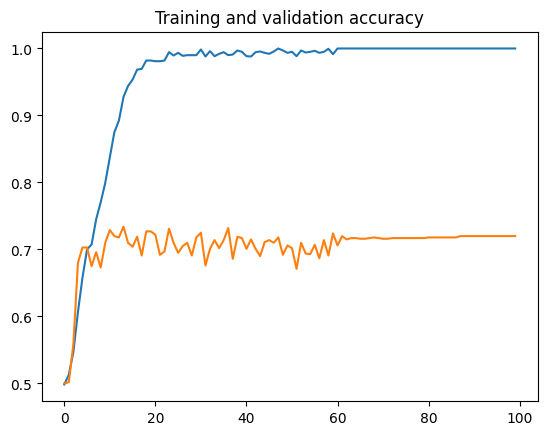

In [ ]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.figure()
plt.plot(epochs, acc, label='Training accuracy')
plt.plot(epochs, val_acc, label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.show()

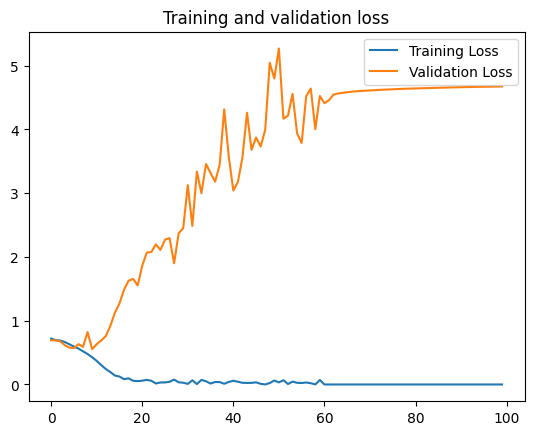

In [ ]:
plt.figure()

plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

To Avoid  this **Overfitting**
we can apply a simple yet very effective technique here called **Image Augmentation** where we change the images a bit by rotating them, squashing them, etc.

We can implement this using the ImageDataGenerator Class



```
train_datagen = ImageDataGenerator(
                                    rescale=1./255,
                                    rotation_range=40,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    shear_range=0.2,
                                    zoom_range=0.2,
                                    horizontal_flip=True,
                                    fill_mode='nearest')
```

Some options that are available:



*   rotation_range is a value in degrees (0–180), a range within which to randomly rotate pictures.
*   width_shift and height_shift are ranges (as a fraction of total width or height) within which to randomly     translate pictures vertically or horizontally
*   shear_range is for randomly applying shearing transformations
*   zoom_range is for randomly zooming inside pictures
*   horizontal_flip is for randomly flipping half of the images horizontally. This is relevant when there are no assumptions of horizontal assymmetry (e.g. real-world pictures)
*   fill_mode is the strategy used for filling in newly created pixels, which can appear after a rotation or a width/height shift





**Here's the code with added Image Augmentation.**

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

model = Sequential()
model.add(Conv2D(filters =32, kernel_size=(3,3), activation='relu', input_shape=(150, 150, 3)))
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(filters =64, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(Conv2D(filters =128, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(Conv2D(filters =128, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(learning_rate=1e-4),
              metrics=['accuracy'])

train_datagen = ImageDataGenerator(
                                    rescale=1./255,
                                    rotation_range=40,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    shear_range=0.2,
                                    zoom_range=0.2,
                                    horizontal_flip=True,
                                    fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
                                                    train_dir,  # This is the source directory for training images
                                                    target_size=(150, 150),  # All images will be resized to 150x150
                                                    batch_size=20,
                                                    # Since we use binary_crossentropy loss, we need binary labels
                                                    class_mode='binary')

# Flow validation images in batches of 20 using test_datagen generator
validation_generator = test_datagen.flow_from_directory(
                                                        validation_dir,
                                                        target_size=(150, 150),
                                                        batch_size=20,
                                                        class_mode='binary')

history = model.fit(
                    train_generator,
                    steps_per_epoch=100,  # 2000 images = batch_size * steps
                    epochs=100,
                    validation_data=validation_generator,
                    validation_steps=50,  # 1000 images = batch_size * steps
                    verbose=2)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/100
100/100 - 18s - loss: 0.7259 - accuracy: 0.4840 - val_loss: 0.6921 - val_accuracy: 0.5800 - 18s/epoch - 176ms/step
Epoch 2/100
100/100 - 17s - loss: 0.6941 - accuracy: 0.5125 - val_loss: 0.6869 - val_accuracy: 0.5380 - 17s/epoch - 169ms/step
Epoch 3/100
100/100 - 15s - loss: 0.6862 - accuracy: 0.5595 - val_loss: 0.6731 - val_accuracy: 0.5750 - 15s/epoch - 151ms/step
Epoch 4/100
100/100 - 24s - loss: 0.6770 - accuracy: 0.5705 - val_loss: 0.6582 - val_accuracy: 0.5890 - 24s/epoch - 237ms/step
Epoch 5/100
100/100 - 16s - loss: 0.6598 - accuracy: 0.5975 - val_loss: 0.6231 - val_accuracy: 0.6680 - 16s/epoch - 163ms/step
Epoch 6/100
100/100 - 15s - loss: 0.6397 - accuracy: 0.6290 - val_loss: 0.6612 - val_accuracy: 0.6370 - 15s/epoch - 153ms/step
Epoch 7/100
100/100 - 15s - loss: 0.6367 - accuracy: 0.6465 - val_loss: 0.5816 - val_accuracy: 0.6890 - 15s/epoch - 151ms/step
Epoch 8/100
100/100 - 17s -

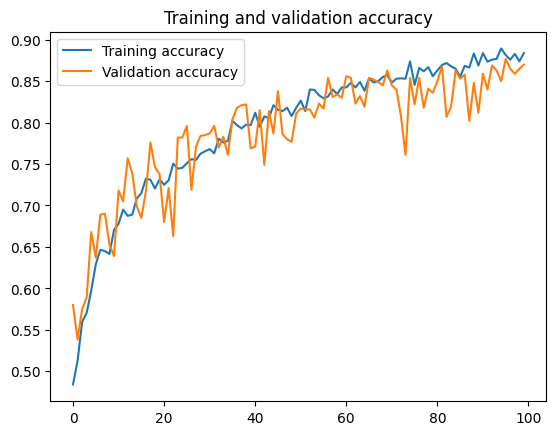

In [ ]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.figure()
plt.plot(epochs, acc, label='Training accuracy')
plt.plot(epochs, val_acc, label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

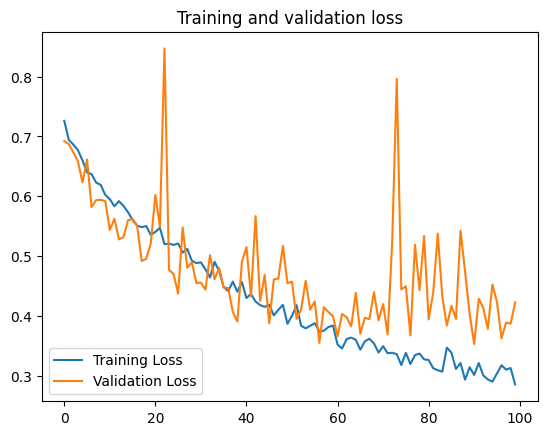

In [ ]:
plt.figure()

plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

As we can see, the accuracy and loss metrics have improved, but we can do better.
Let us try implementing **Droput** which would help us with overfitting.

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dropout

model = Sequential()
model.add(Conv2D(filters =32, kernel_size=(3,3), activation='relu', input_shape=(150, 150, 3)))
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(filters =64, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(Conv2D(filters =128, kernel_size=(3,3), activation='relu'))

model.add(MaxPooling2D(2,2))
model.add(Conv2D(filters =128, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(learning_rate=1e-4),
              metrics=['accuracy'])

# This code has changed. Now instead of the ImageGenerator just rescaling
# the image, we also rotate and do other operations
# Updated to do image augmentation
train_datagen = ImageDataGenerator(
                                    rescale=1./255,
                                    rotation_range=40,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    shear_range=0.2,
                                    zoom_range=0.2,
                                    horizontal_flip=True,
                                    fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
                                                    train_dir,  # This is the source directory for training images
                                                    target_size=(150, 150),  # All images will be resized to 150x150
                                                    batch_size=20,
                                                    # Since we use binary_crossentropy loss, we need binary labels
                                                    class_mode='binary'
                                                    )
# Flow validation images in batches of 20 using test_datagen generator
validation_generator = test_datagen.flow_from_directory(
                                                        validation_dir,
                                                        target_size=(150, 150),
                                                        batch_size=20,
                                                        class_mode='binary'
                                                        )
history = model.fit(
                    train_generator,
                    steps_per_epoch=100,  # 2000 images = batch_size * steps
                    epochs=100,
                    validation_data=validation_generator,
                    validation_steps=50,  # 1000 images = batch_size * steps
                    verbose=2
                    )

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/100
100/100 - 18s - loss: 0.6929 - accuracy: 0.5240 - val_loss: 0.6912 - val_accuracy: 0.5000 - 18s/epoch - 178ms/step
Epoch 2/100
100/100 - 16s - loss: 0.6910 - accuracy: 0.5225 - val_loss: 0.6913 - val_accuracy: 0.5070 - 16s/epoch - 155ms/step
Epoch 3/100
100/100 - 17s - loss: 0.6872 - accuracy: 0.5410 - val_loss: 0.6732 - val_accuracy: 0.5640 - 17s/epoch - 165ms/step
Epoch 4/100
100/100 - 16s - loss: 0.6804 - accuracy: 0.5625 - val_loss: 0.6725 - val_accuracy: 0.5390 - 16s/epoch - 165ms/step
Epoch 5/100
100/100 - 16s - loss: 0.6723 - accuracy: 0.5775 - val_loss: 0.6539 - val_accuracy: 0.6080 - 16s/epoch - 164ms/step
Epoch 6/100
100/100 - 19s - loss: 0.6669 - accuracy: 0.5925 - val_loss: 0.6423 - val_accuracy: 0.6160 - 19s/epoch - 185ms/step
Epoch 7/100
100/100 - 16s - loss: 0.6613 - accuracy: 0.5955 - val_loss: 0.6363 - val_accuracy: 0.6170 - 16s/epoch - 158ms/step
Epoch 8/100
100/100 - 16s -

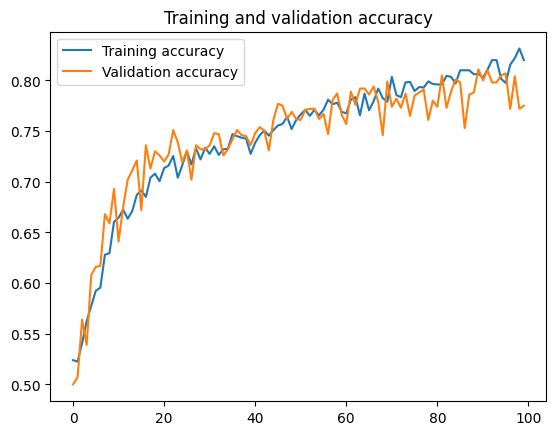

In [ ]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.figure()
plt.plot(epochs, acc, label='Training accuracy')
plt.plot(epochs, val_acc, label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

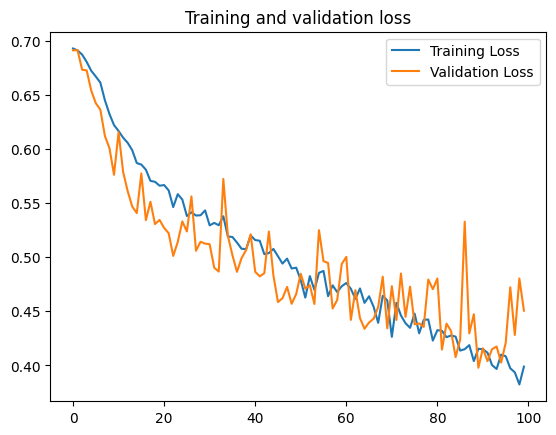

In [ ]:
plt.figure()

plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

## **Our Model in action**

Let's check out our model. The following code lets us choose one or more images from the file system. Then the images run through our model and give out results.

In [ ]:
import numpy as np
from google.colab import files
from tensorflow.keras.preprocessing import image

uploaded = files.upload()

classes = {0:"it's a cat",
           1:"it's a dog",}

for i in uploaded.keys():
    # predicting images
    path = '/content/' + i
    #resize to the right input format
    img = image.load_img(path, target_size=(150, 150))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)

    images = np.vstack([x])
    pred = model.predict(images)
    print(pred)
    pred = np.where((pred)> 0.5, 1, 0)[0][0]
    print(pred)
    res = classes[pred]
    print(res)

In [ ]:
model.save('my_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
